In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                      | 0/60000 [00:00<?, ?it/s]

 12%|██████████████▉                                                                                                         | 7467/60000 [00:00<00:00, 74665.44it/s]

 25%|█████████████████████████████▌                                                                                         | 14934/60000 [00:00<00:00, 72667.85it/s]

 37%|████████████████████████████████████████████                                                                           | 22205/60000 [00:00<00:00, 68924.30it/s]

 49%|██████████████████████████████████████████████████████████▊                                                            | 29645/60000 [00:00<00:00, 70995.45it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                             | 37216/60000 [00:00<00:00, 72649.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▊                              | 44760/60000 [00:00<00:00, 73579.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 52338/60000 [00:00<00:00, 74289.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 59777/60000 [00:00<00:00, 71304.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71833.99it/s]

  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 7500/10000 [00:00<00:00, 74991.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 74494.15it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 dqkmlnla


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/375 [00:00<?, ?it/s]

  0%|▎                                                                                                                               | 1/375 [00:00<03:53,  1.60it/s]

  1%|█                                                                                                                               | 3/375 [00:00<01:18,  4.76it/s]

  1%|█▋                                                                                                                              | 5/375 [00:00<00:48,  7.62it/s]

  2%|██▍                                                                                                                             | 7/375 [00:00<00:36, 10.18it/s]

  2%|███                                                                                                                             | 9/375 [00:01<00:29, 12.28it/s]

  3%|███▋                                                                                                                           | 11/375 [00:01<00:26, 13.93it/s]

  3%|████▍                                                                                                                          | 13/375 [00:01<00:23, 15.20it/s]

  4%|█████                                                                                                                          | 15/375 [00:01<00:22, 16.15it/s]

  5%|█████▊                                                                                                                         | 17/375 [00:01<00:21, 16.85it/s]

  5%|██████▍                                                                                                                        | 19/375 [00:01<00:20, 17.35it/s]

  6%|███████                                                                                                                        | 21/375 [00:01<00:19, 17.72it/s]

  6%|███████▊                                                                                                                       | 23/375 [00:01<00:19, 17.97it/s]

  7%|████████▍                                                                                                                      | 25/375 [00:01<00:19, 18.15it/s]

  7%|█████████▏                                                                                                                     | 27/375 [00:02<00:19, 18.29it/s]

  8%|█████████▊                                                                                                                     | 29/375 [00:02<00:18, 18.38it/s]

  8%|██████████▍                                                                                                                    | 31/375 [00:02<00:18, 18.45it/s]

  9%|███████████▏                                                                                                                   | 33/375 [00:02<00:18, 18.47it/s]

  9%|███████████▊                                                                                                                   | 35/375 [00:02<00:18, 18.51it/s]

 10%|████████████▌                                                                                                                  | 37/375 [00:02<00:18, 18.54it/s]

 10%|█████████████▏                                                                                                                 | 39/375 [00:02<00:18, 18.56it/s]

 11%|█████████████▉                                                                                                                 | 41/375 [00:02<00:17, 18.57it/s]

 11%|██████████████▌                                                                                                                | 43/375 [00:02<00:17, 18.58it/s]

 12%|███████████████▏                                                                                                               | 45/375 [00:03<00:17, 18.59it/s]

 13%|███████████████▉                                                                                                               | 47/375 [00:03<00:17, 18.59it/s]

 13%|████████████████▌                                                                                                              | 49/375 [00:03<00:17, 18.59it/s]

 14%|█████████████████▎                                                                                                             | 51/375 [00:03<00:17, 18.60it/s]

 14%|█████████████████▉                                                                                                             | 53/375 [00:03<00:17, 18.60it/s]

 15%|██████████████████▋                                                                                                            | 55/375 [00:03<00:17, 18.55it/s]

 15%|███████████████████▎                                                                                                           | 57/375 [00:03<00:17, 18.56it/s]

 16%|███████████████████▉                                                                                                           | 59/375 [00:03<00:17, 18.57it/s]

 16%|████████████████████▋                                                                                                          | 61/375 [00:03<00:16, 18.58it/s]

 17%|█████████████████████▎                                                                                                         | 63/375 [00:03<00:16, 18.58it/s]

 17%|██████████████████████                                                                                                         | 65/375 [00:04<00:16, 18.59it/s]

 18%|██████████████████████▋                                                                                                        | 67/375 [00:04<00:16, 18.60it/s]

 18%|███████████████████████▎                                                                                                       | 69/375 [00:04<00:16, 18.60it/s]

 19%|████████████████████████                                                                                                       | 71/375 [00:04<00:16, 18.60it/s]

 19%|████████████████████████▋                                                                                                      | 73/375 [00:04<00:16, 18.59it/s]

 20%|█████████████████████████▍                                                                                                     | 75/375 [00:04<00:16, 18.60it/s]

 21%|██████████████████████████                                                                                                     | 77/375 [00:04<00:16, 18.60it/s]

 21%|██████████████████████████▊                                                                                                    | 79/375 [00:04<00:15, 18.61it/s]

 22%|███████████████████████████▍                                                                                                   | 81/375 [00:04<00:15, 18.61it/s]

 22%|████████████████████████████                                                                                                   | 83/375 [00:05<00:15, 18.61it/s]

 23%|████████████████████████████▊                                                                                                  | 85/375 [00:05<00:15, 18.64it/s]

 23%|█████████████████████████████▍                                                                                                 | 87/375 [00:05<00:15, 18.67it/s]

 24%|██████████████████████████████▏                                                                                                | 89/375 [00:05<00:15, 18.69it/s]

 24%|██████████████████████████████▊                                                                                                | 91/375 [00:05<00:15, 18.70it/s]

 25%|███████████████████████████████▍                                                                                               | 93/375 [00:05<00:15, 18.71it/s]

 25%|████████████████████████████████▏                                                                                              | 95/375 [00:05<00:14, 18.70it/s]

 26%|████████████████████████████████▊                                                                                              | 97/375 [00:05<00:14, 18.71it/s]

 26%|█████████████████████████████████▌                                                                                             | 99/375 [00:05<00:14, 18.72it/s]

 27%|█████████████████████████████████▉                                                                                            | 101/375 [00:06<00:14, 18.72it/s]

 27%|██████████████████████████████████▌                                                                                           | 103/375 [00:06<00:14, 18.72it/s]

 28%|███████████████████████████████████▎                                                                                          | 105/375 [00:06<00:14, 18.70it/s]

 29%|███████████████████████████████████▉                                                                                          | 107/375 [00:06<00:14, 18.69it/s]

 29%|████████████████████████████████████▌                                                                                         | 109/375 [00:06<00:14, 18.70it/s]

 30%|█████████████████████████████████████▎                                                                                        | 111/375 [00:06<00:14, 18.71it/s]

 30%|█████████████████████████████████████▉                                                                                        | 113/375 [00:06<00:14, 18.71it/s]

 31%|██████████████████████████████████████▋                                                                                       | 115/375 [00:06<00:13, 18.71it/s]

 31%|███████████████████████████████████████▎                                                                                      | 117/375 [00:06<00:13, 18.71it/s]

 32%|███████████████████████████████████████▉                                                                                      | 119/375 [00:06<00:13, 18.73it/s]

 32%|████████████████████████████████████████▋                                                                                     | 121/375 [00:07<00:13, 18.72it/s]

 33%|█████████████████████████████████████████▎                                                                                    | 123/375 [00:07<00:13, 18.72it/s]

 33%|██████████████████████████████████████████                                                                                    | 125/375 [00:07<00:13, 18.73it/s]

 34%|██████████████████████████████████████████▋                                                                                   | 127/375 [00:07<00:13, 18.73it/s]

 34%|███████████████████████████████████████████▎                                                                                  | 129/375 [00:07<00:13, 18.73it/s]

 35%|████████████████████████████████████████████                                                                                  | 131/375 [00:07<00:13, 18.73it/s]

 35%|████████████████████████████████████████████▋                                                                                 | 133/375 [00:07<00:12, 18.73it/s]

 36%|█████████████████████████████████████████████▎                                                                                | 135/375 [00:07<00:12, 18.73it/s]

 37%|██████████████████████████████████████████████                                                                                | 137/375 [00:07<00:12, 18.72it/s]

 37%|██████████████████████████████████████████████▋                                                                               | 139/375 [00:08<00:12, 18.73it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 141/375 [00:08<00:12, 18.73it/s]

 38%|████████████████████████████████████████████████                                                                              | 143/375 [00:08<00:12, 18.74it/s]

 39%|████████████████████████████████████████████████▋                                                                             | 145/375 [00:08<00:12, 18.73it/s]

 39%|█████████████████████████████████████████████████▍                                                                            | 147/375 [00:08<00:12, 18.73it/s]

 40%|██████████████████████████████████████████████████                                                                            | 149/375 [00:08<00:12, 18.73it/s]

 40%|██████████████████████████████████████████████████▋                                                                           | 151/375 [00:08<00:11, 18.73it/s]

 41%|███████████████████████████████████████████████████▍                                                                          | 153/375 [00:08<00:11, 18.73it/s]

 41%|████████████████████████████████████████████████████                                                                          | 155/375 [00:08<00:11, 18.73it/s]

 42%|████████████████████████████████████████████████████▊                                                                         | 157/375 [00:09<00:11, 18.73it/s]

 42%|█████████████████████████████████████████████████████▍                                                                        | 159/375 [00:09<00:11, 18.70it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 161/375 [00:09<00:11, 18.70it/s]

 43%|██████████████████████████████████████████████████████▊                                                                       | 163/375 [00:09<00:11, 18.71it/s]

 44%|███████████████████████████████████████████████████████▍                                                                      | 165/375 [00:09<00:11, 18.72it/s]

 45%|████████████████████████████████████████████████████████                                                                      | 167/375 [00:09<00:11, 18.71it/s]

 45%|████████████████████████████████████████████████████████▊                                                                     | 169/375 [00:09<00:11, 18.72it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                    | 171/375 [00:09<00:10, 18.73it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                   | 173/375 [00:09<00:10, 18.73it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                   | 175/375 [00:09<00:10, 18.72it/s]

 47%|███████████████████████████████████████████████████████████▍                                                                  | 177/375 [00:10<00:10, 18.73it/s]

 48%|████████████████████████████████████████████████████████████▏                                                                 | 179/375 [00:10<00:10, 18.73it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                 | 181/375 [00:10<00:10, 18.73it/s]

 49%|█████████████████████████████████████████████████████████████▍                                                                | 183/375 [00:10<00:10, 18.73it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                               | 185/375 [00:10<00:10, 18.73it/s]

 50%|██████████████████████████████████████████████████████████████▊                                                               | 187/375 [00:10<00:10, 18.71it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                              | 189/375 [00:10<00:09, 18.72it/s]

 51%|████████████████████████████████████████████████████████████████▏                                                             | 191/375 [00:10<00:09, 18.72it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                             | 193/375 [00:10<00:09, 18.72it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                            | 195/375 [00:11<00:09, 18.72it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                           | 197/375 [00:11<00:09, 18.72it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                           | 199/375 [00:11<00:09, 18.73it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                          | 201/375 [00:11<00:09, 18.73it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                         | 203/375 [00:11<00:09, 18.73it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 205/375 [00:11<00:09, 18.72it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                        | 207/375 [00:11<00:08, 18.72it/s]

 56%|██████████████████████████████████████████████████████████████████████▏                                                       | 209/375 [00:11<00:08, 18.72it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 211/375 [00:11<00:08, 18.72it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 213/375 [00:12<00:08, 18.73it/s]

 57%|████████████████████████████████████████████████████████████████████████▏                                                     | 215/375 [00:12<00:08, 18.73it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                     | 217/375 [00:12<00:08, 18.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                    | 219/375 [00:12<00:08, 18.73it/s]

 59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 221/375 [00:12<00:08, 18.73it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                   | 223/375 [00:12<00:08, 18.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 225/375 [00:12<00:08, 18.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 227/375 [00:12<00:07, 18.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 229/375 [00:12<00:07, 18.74it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 231/375 [00:12<00:07, 18.74it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 233/375 [00:13<00:07, 18.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 235/375 [00:13<00:07, 18.74it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 237/375 [00:13<00:07, 18.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▎                                             | 239/375 [00:13<00:07, 18.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 241/375 [00:13<00:07, 18.64it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 243/375 [00:13<00:07, 18.67it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 245/375 [00:13<00:06, 18.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                           | 247/375 [00:13<00:06, 18.69it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                          | 249/375 [00:13<00:06, 18.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                         | 251/375 [00:14<00:06, 18.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                         | 253/375 [00:14<00:06, 18.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 255/375 [00:14<00:06, 18.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                       | 257/375 [00:14<00:06, 18.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 259/375 [00:14<00:06, 18.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                      | 261/375 [00:14<00:06, 18.73it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 263/375 [00:14<00:05, 18.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 265/375 [00:14<00:05, 18.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 267/375 [00:14<00:05, 18.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 269/375 [00:14<00:05, 18.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 271/375 [00:15<00:05, 18.73it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 273/375 [00:15<00:05, 18.73it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 275/375 [00:15<00:05, 18.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 277/375 [00:15<00:05, 18.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                | 279/375 [00:15<00:05, 18.73it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▍                               | 281/375 [00:15<00:05, 18.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                               | 283/375 [00:15<00:04, 18.72it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▊                              | 285/375 [00:15<00:04, 18.73it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 287/375 [00:15<00:04, 18.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 289/375 [00:16<00:04, 18.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/375 [00:16<00:04, 18.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 293/375 [00:16<00:04, 18.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                           | 295/375 [00:16<00:04, 18.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 297/375 [00:16<00:04, 18.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 299/375 [00:16<00:04, 18.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 301/375 [00:16<00:03, 18.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 303/375 [00:16<00:03, 18.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 305/375 [00:16<00:03, 18.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 307/375 [00:17<00:03, 18.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 309/375 [00:17<00:03, 18.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 311/375 [00:17<00:03, 18.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 313/375 [00:17<00:03, 18.71it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 315/375 [00:17<00:03, 18.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 317/375 [00:17<00:03, 18.71it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 319/375 [00:17<00:02, 18.73it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 321/375 [00:17<00:02, 18.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 323/375 [00:17<00:02, 18.73it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 325/375 [00:17<00:02, 18.74it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 327/375 [00:18<00:02, 18.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 329/375 [00:18<00:02, 18.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 331/375 [00:18<00:02, 18.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 333/375 [00:18<00:02, 18.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 335/375 [00:18<00:02, 18.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 337/375 [00:18<00:02, 18.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 339/375 [00:18<00:01, 18.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 341/375 [00:18<00:01, 18.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 343/375 [00:18<00:01, 18.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 345/375 [00:19<00:01, 18.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 347/375 [00:19<00:01, 18.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 349/375 [00:19<00:01, 18.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 351/375 [00:19<00:01, 18.72it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 353/375 [00:19<00:01, 18.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 355/375 [00:19<00:01, 18.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 357/375 [00:19<00:00, 18.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 359/375 [00:19<00:00, 18.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 361/375 [00:19<00:00, 18.73it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 363/375 [00:20<00:00, 18.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 365/375 [00:20<00:00, 18.73it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 367/375 [00:20<00:00, 18.71it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 369/375 [00:20<00:00, 18.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 371/375 [00:20<00:00, 18.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 373/375 [00:20<00:00, 18.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.14it/s]

train - OK


  0%|                                                                                                                                         | 0/94 [00:00<?, ?it/s]

  1%|█▎                                                                                                                               | 1/94 [00:00<00:11,  7.80it/s]

  3%|████                                                                                                                             | 3/94 [00:00<00:06, 13.67it/s]

  5%|██████▊                                                                                                                          | 5/94 [00:00<00:05, 15.85it/s]

  7%|█████████▌                                                                                                                       | 7/94 [00:00<00:05, 16.95it/s]

 10%|████████████▎                                                                                                                    | 9/94 [00:00<00:04, 17.55it/s]

 12%|██████████████▉                                                                                                                 | 11/94 [00:00<00:04, 17.94it/s]

 14%|█████████████████▋                                                                                                              | 13/94 [00:00<00:04, 18.18it/s]

 16%|████████████████████▍                                                                                                           | 15/94 [00:00<00:04, 18.34it/s]

 18%|███████████████████████▏                                                                                                        | 17/94 [00:00<00:04, 18.44it/s]

 20%|█████████████████████████▊                                                                                                      | 19/94 [00:01<00:04, 18.52it/s]

 22%|████████████████████████████▌                                                                                                   | 21/94 [00:01<00:03, 18.56it/s]

 24%|███████████████████████████████▎                                                                                                | 23/94 [00:01<00:03, 18.61it/s]

 27%|██████████████████████████████████                                                                                              | 25/94 [00:01<00:03, 18.61it/s]

 29%|████████████████████████████████████▊                                                                                           | 27/94 [00:01<00:03, 18.64it/s]

 31%|███████████████████████████████████████▍                                                                                        | 29/94 [00:01<00:03, 18.67it/s]

 33%|██████████████████████████████████████████▏                                                                                     | 31/94 [00:01<00:03, 18.68it/s]

 35%|████████████████████████████████████████████▉                                                                                   | 33/94 [00:01<00:03, 18.68it/s]

 37%|███████████████████████████████████████████████▋                                                                                | 35/94 [00:01<00:03, 18.68it/s]

 39%|██████████████████████████████████████████████████▍                                                                             | 37/94 [00:02<00:03, 18.68it/s]

 41%|█████████████████████████████████████████████████████                                                                           | 39/94 [00:02<00:02, 18.67it/s]

 44%|███████████████████████████████████████████████████████▊                                                                        | 41/94 [00:02<00:02, 18.67it/s]

 46%|██████████████████████████████████████████████████████████▌                                                                     | 43/94 [00:02<00:02, 18.68it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                  | 45/94 [00:02<00:02, 18.67it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 47/94 [00:02<00:02, 18.68it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                             | 49/94 [00:02<00:02, 18.68it/s]

 54%|█████████████████████████████████████████████████████████████████████▍                                                          | 51/94 [00:02<00:02, 18.68it/s]

 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 53/94 [00:02<00:02, 18.69it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 55/94 [00:03<00:02, 18.70it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 57/94 [00:03<00:01, 18.68it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 59/94 [00:03<00:01, 18.69it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 61/94 [00:03<00:01, 18.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 63/94 [00:03<00:01, 18.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 65/94 [00:03<00:01, 18.70it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 67/94 [00:03<00:01, 18.68it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 69/94 [00:03<00:01, 18.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 71/94 [00:03<00:01, 18.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 73/94 [00:03<00:01, 18.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 75/94 [00:04<00:01, 18.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 77/94 [00:04<00:00, 18.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 79/94 [00:04<00:00, 18.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 81/94 [00:04<00:00, 18.70it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 83/94 [00:04<00:00, 18.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 85/94 [00:04<00:00, 18.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 87/94 [00:04<00:00, 18.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 89/94 [00:04<00:00, 18.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 91/94 [00:04<00:00, 18.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 93/94 [00:05<00:00, 18.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.26it/s]

val - OK


  0%|                                                                                                                                         | 0/79 [00:00<?, ?it/s]

  1%|█▋                                                                                                                               | 1/79 [00:00<00:09,  7.88it/s]

  4%|████▉                                                                                                                            | 3/79 [00:00<00:05, 13.69it/s]

  6%|████████▏                                                                                                                        | 5/79 [00:00<00:04, 15.86it/s]

  9%|███████████▍                                                                                                                     | 7/79 [00:00<00:04, 16.93it/s]

 11%|██████████████▋                                                                                                                  | 9/79 [00:00<00:03, 17.54it/s]

 14%|█████████████████▊                                                                                                              | 11/79 [00:00<00:03, 17.91it/s]

 16%|█████████████████████                                                                                                           | 13/79 [00:00<00:03, 18.15it/s]

 19%|████████████████████████▎                                                                                                       | 15/79 [00:00<00:03, 18.30it/s]

 22%|███████████████████████████▌                                                                                                    | 17/79 [00:00<00:03, 18.41it/s]

 24%|██████████████████████████████▊                                                                                                 | 19/79 [00:01<00:03, 18.22it/s]

 27%|██████████████████████████████████                                                                                              | 21/79 [00:01<00:03, 18.35it/s]

 29%|█████████████████████████████████████▎                                                                                          | 23/79 [00:01<00:03, 18.44it/s]

 32%|████████████████████████████████████████▌                                                                                       | 25/79 [00:01<00:02, 18.49it/s]

 34%|███████████████████████████████████████████▋                                                                                    | 27/79 [00:01<00:02, 18.51it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 29/79 [00:01<00:02, 18.55it/s]

 39%|██████████████████████████████████████████████████▏                                                                             | 31/79 [00:01<00:02, 18.58it/s]

 42%|█████████████████████████████████████████████████████▍                                                                          | 33/79 [00:01<00:02, 18.61it/s]

 44%|████████████████████████████████████████████████████████▋                                                                       | 35/79 [00:01<00:02, 18.62it/s]

 47%|███████████████████████████████████████████████████████████▉                                                                    | 37/79 [00:02<00:02, 18.62it/s]

 49%|███████████████████████████████████████████████████████████████▏                                                                | 39/79 [00:02<00:02, 18.63it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 41/79 [00:02<00:02, 18.64it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 43/79 [00:02<00:01, 18.66it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 45/79 [00:02<00:01, 18.66it/s]

 59%|████████████████████████████████████████████████████████████████████████████▏                                                   | 47/79 [00:02<00:01, 18.67it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 49/79 [00:02<00:01, 18.70it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 51/79 [00:02<00:01, 18.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 53/79 [00:02<00:01, 18.70it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 55/79 [00:03<00:01, 18.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57/79 [00:03<00:01, 18.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59/79 [00:03<00:01, 18.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61/79 [00:03<00:00, 18.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63/79 [00:03<00:00, 18.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65/79 [00:03<00:00, 18.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67/79 [00:03<00:00, 18.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69/79 [00:03<00:00, 18.73it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71/79 [00:03<00:00, 18.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73/79 [00:03<00:00, 18.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75/79 [00:04<00:00, 18.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77/79 [00:04<00:00, 18.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.24it/s]

test InD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:04, 21.80it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:04, 21.85it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:00<00:04, 21.90it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:00<00:04, 21.91it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:00<00:03, 21.93it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:00<00:03, 21.94it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:00<00:03, 21.94it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:01<00:03, 21.95it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:01<00:03, 21.95it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:01<00:03, 21.95it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:01<00:03, 21.96it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:01<00:02, 21.96it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:01<00:02, 21.96it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:01<00:02, 21.97it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:02<00:02, 21.97it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:02<00:02, 21.97it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:02<00:02, 21.97it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:02<00:02, 21.97it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:02<00:01, 21.97it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:02<00:01, 21.97it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:02<00:01, 21.98it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:03<00:01, 21.97it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:03<00:01, 21.97it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:03<00:01, 21.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:03<00:01, 21.97it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:03<00:01, 21.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:03<00:00, 21.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:03<00:00, 21.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:03<00:00, 21.97it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:04<00:00, 21.97it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:04<00:00, 21.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:04<00:00, 21.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.96it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(48000, 1, 32, 32) (48000, 256) (48000, 768) (48000, 1, 32, 32) (48000,)
(12000, 1, 32, 32) (12000, 256) (12000, 768) (12000, 1, 32, 32) (12000,)
(10000, 1, 32, 32) (10000, 256) (10000, 768) (10000, 1, 32, 32) (10000,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


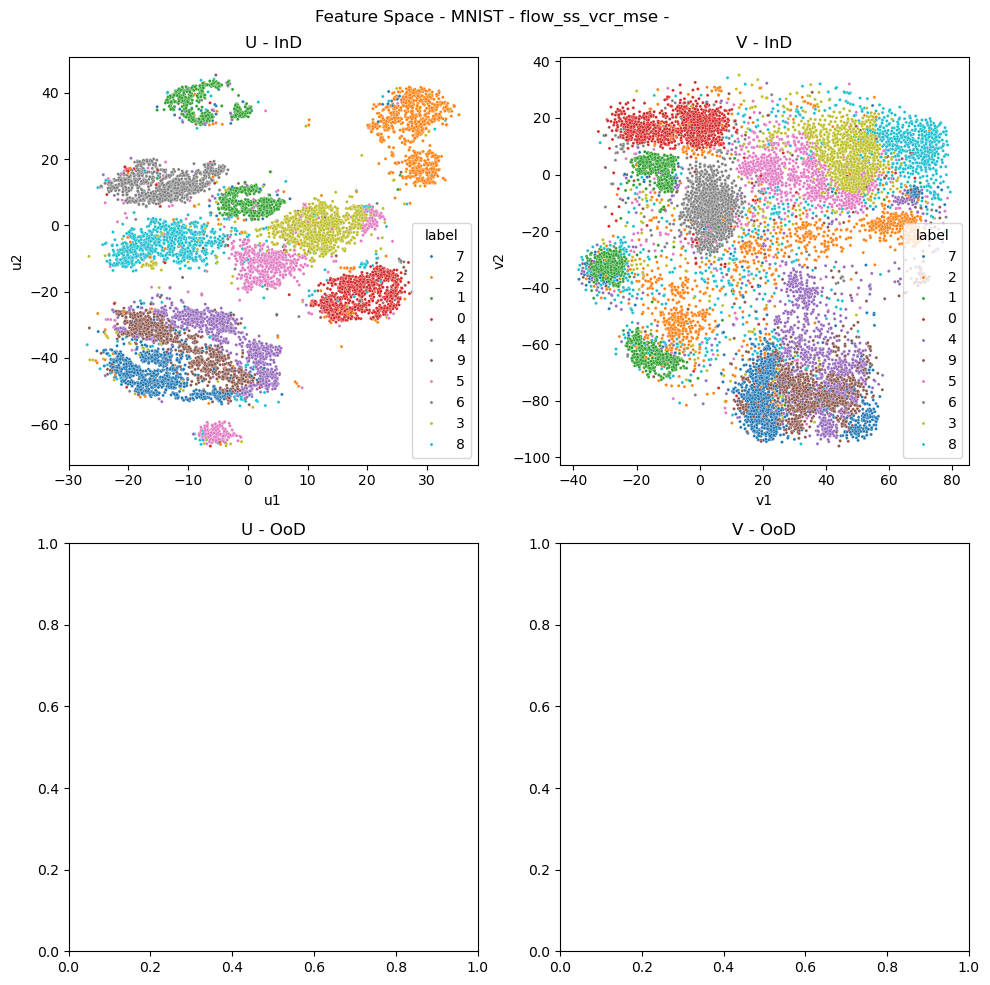

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:01,  1.89it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:01<00:01,  1.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:01<00:00,  1.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.26s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.27s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.28s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.30s/it]

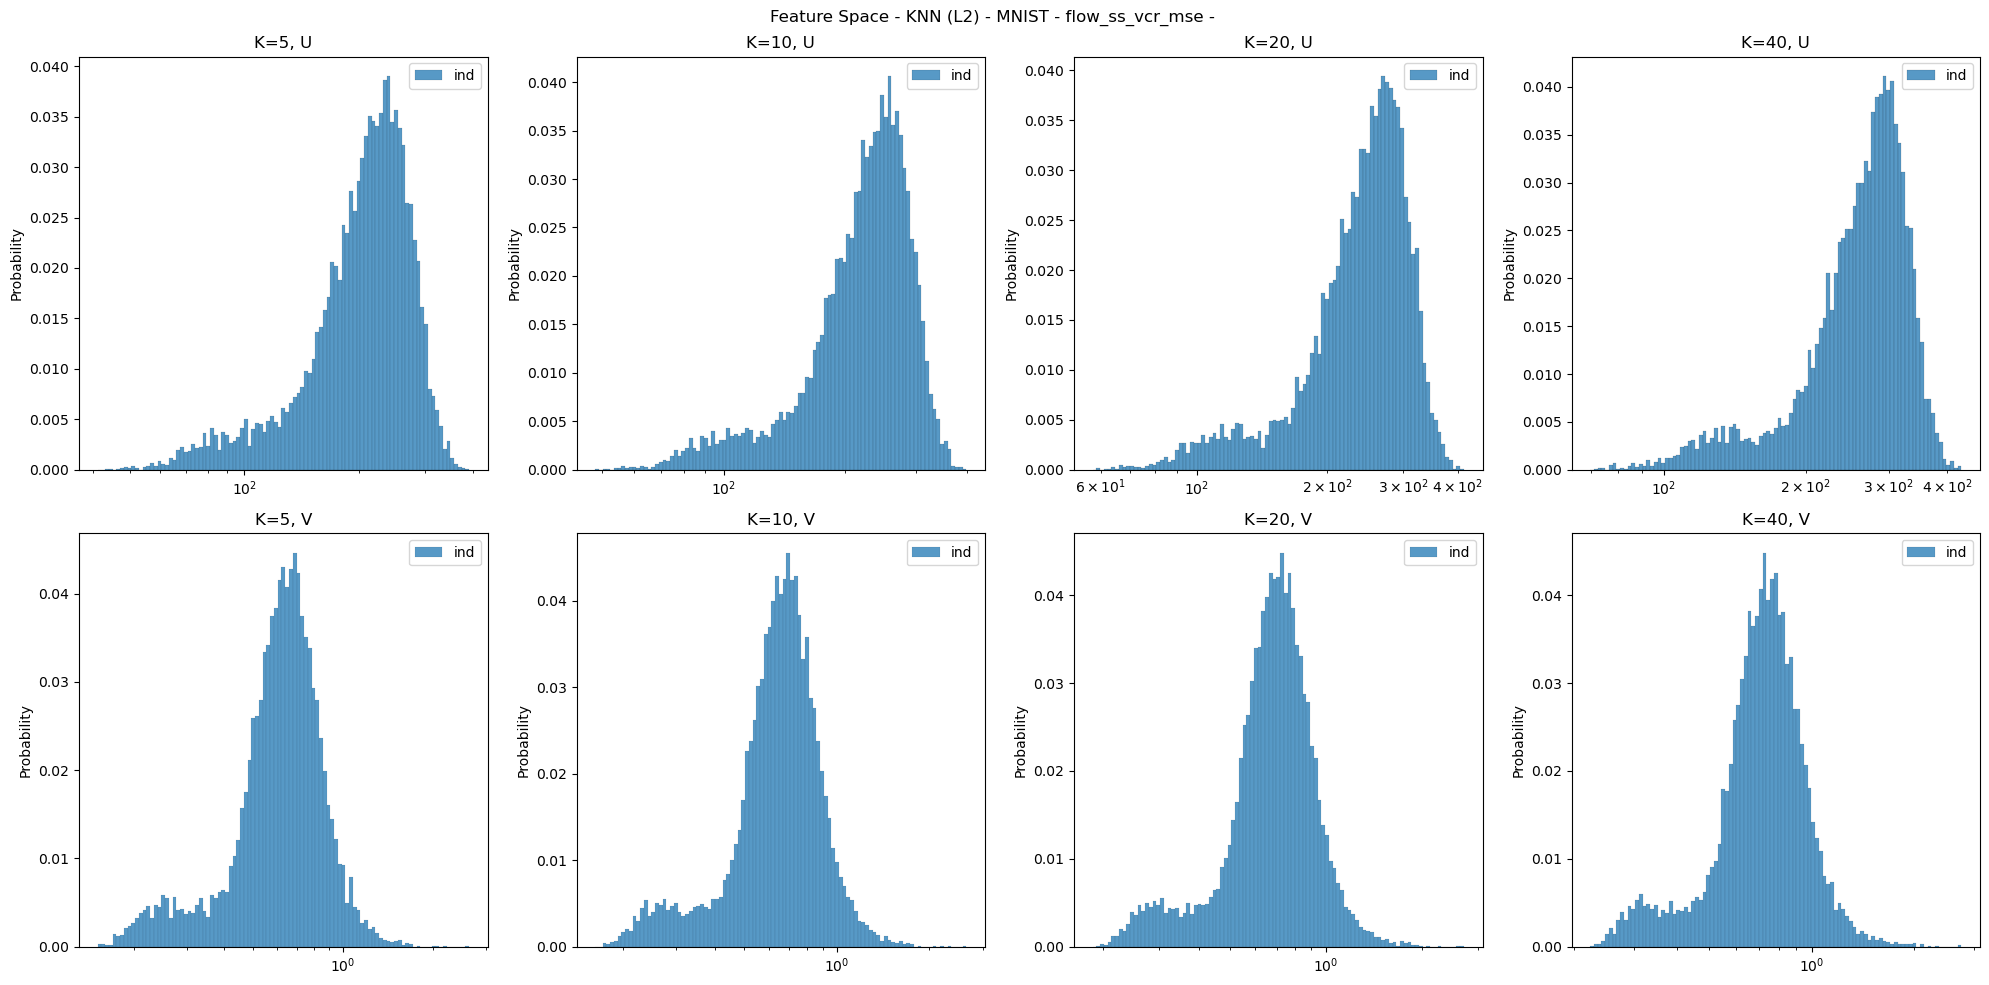

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:02,  1.50it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:01<00:01,  1.73it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:01<00:00,  1.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.24s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.25s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.26s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/it]

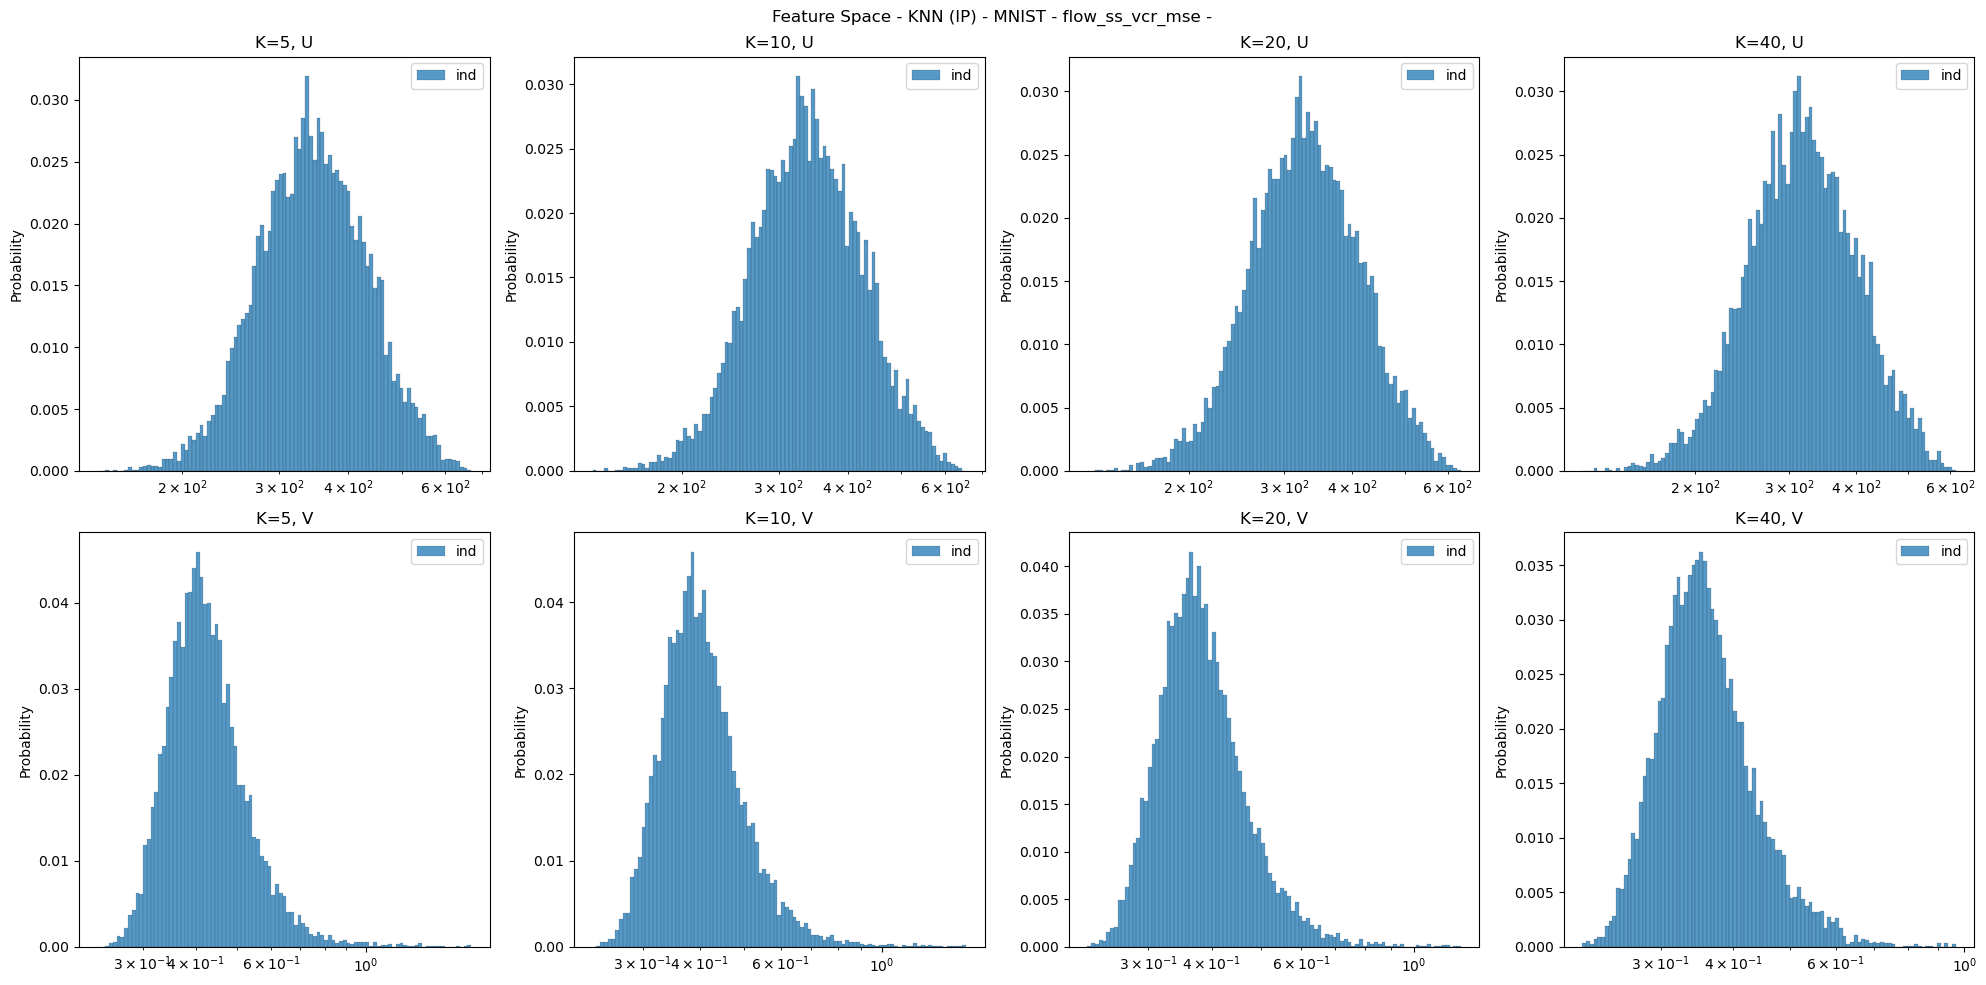

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

20.764482 2.0695543 0.8649212 0.11527661
20.711119 2.0546055 0.86724406 0.116387755
20.851507 2.0569322 0.86075896 0.111787155
34.58174 2.1397343 26.551538 0.8020254


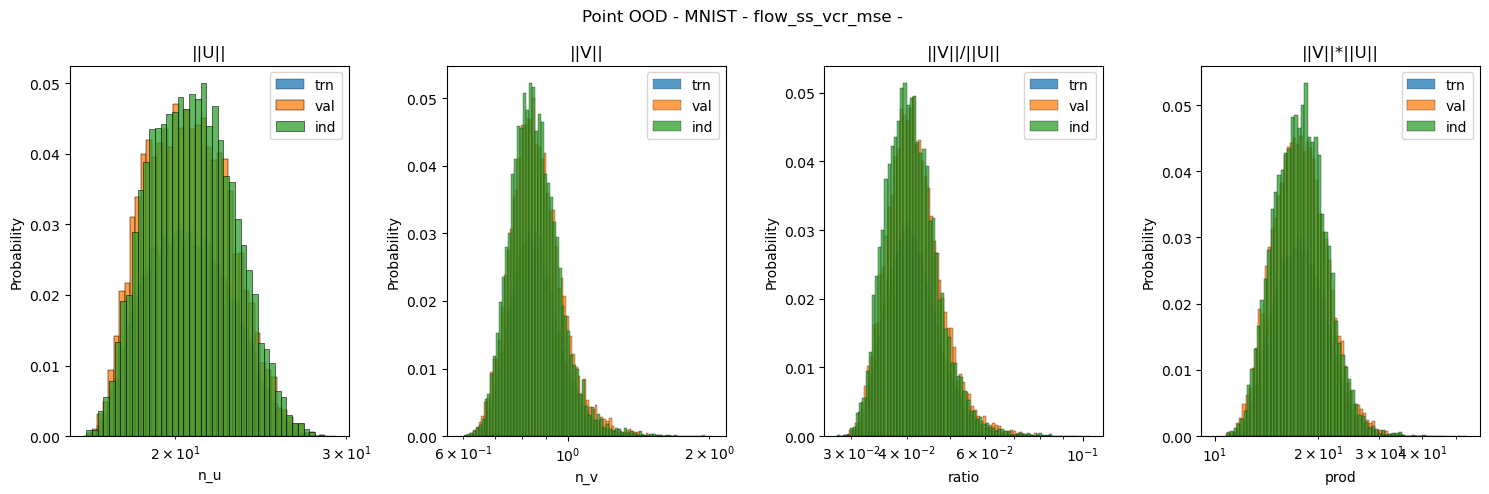

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


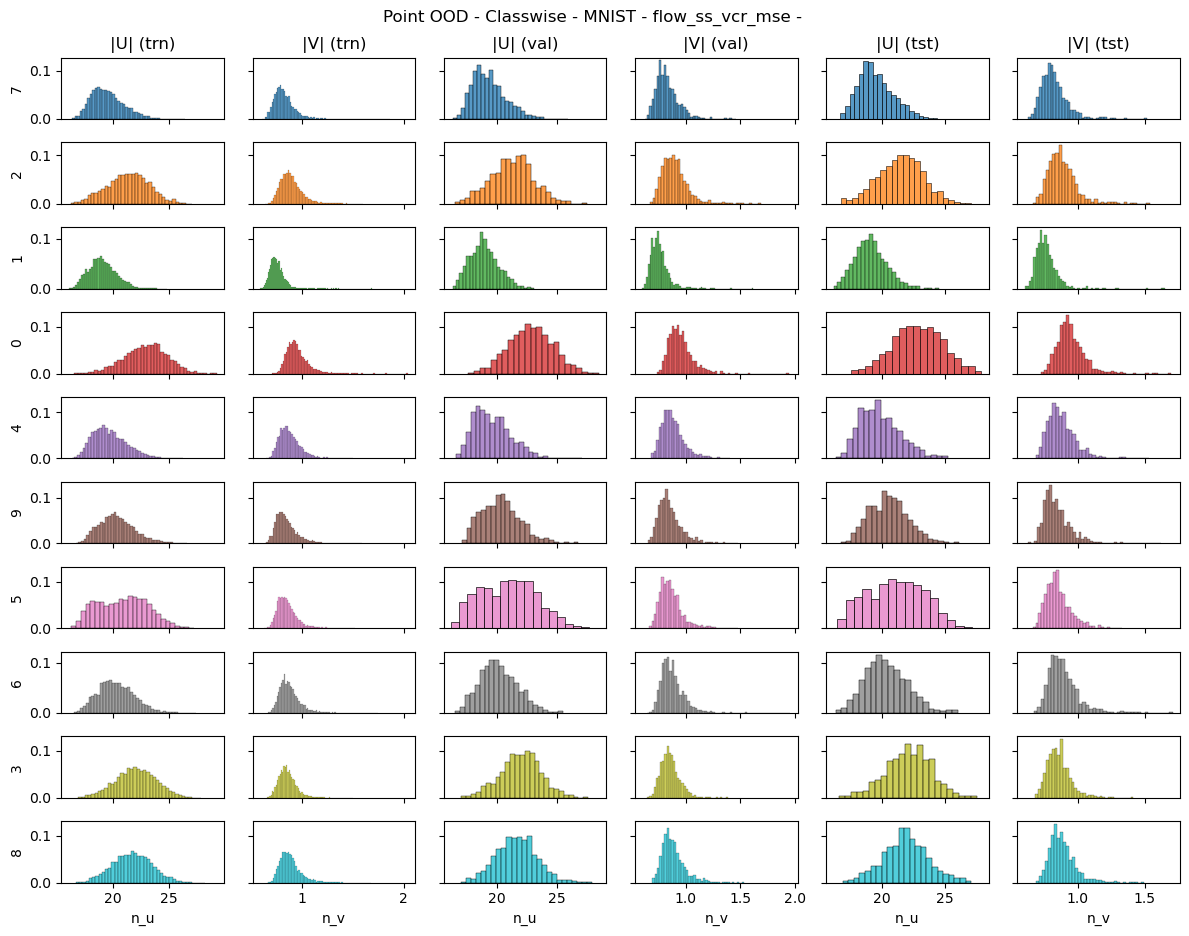

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

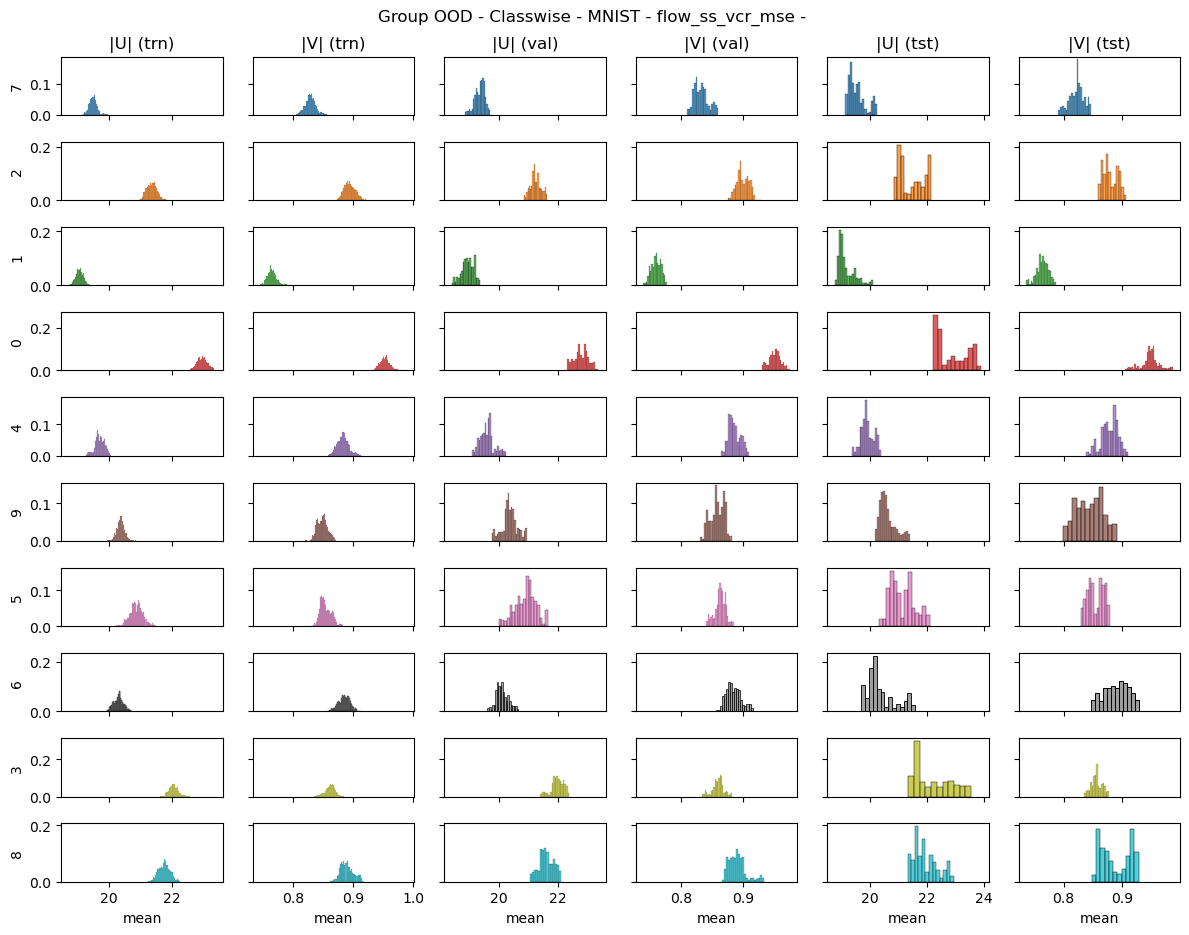

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

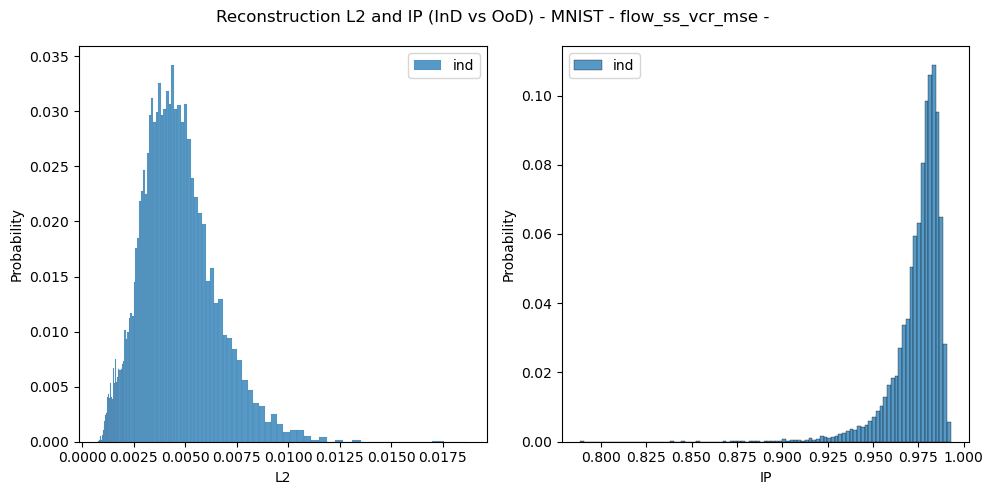

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()